<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/Cohere_and_Open_Source_Embedding_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Packages and Setup Variables**

In [ ]:
# !pip install -q llama-index==0.13.3 openai==1.102.0 llama-index-finetuning==0.4.0 llama-index-embeddings-huggingface==0.6.0 \
#                 llama-index-embeddings-cohere==0.6.0 cohere==5.17.0 tiktoken==0.11.0 llama-index-vector-stores-chroma==0.5.2 \
#                 chromadb==1.0.20 llama-index-llms-google-genai==0.3.0 llama-index-embeddings-instructor==0.4.0 jedi==0.19.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/67.3 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.3/295.3 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.9 MB/s eta 0:00:0

In [1]:
import os

# Set the following API Keys in the Python environment. Will be used later.
# os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_KEY>"
# os.environ["CO_API_KEY"] = "<YOUR_OPENAI_KEY>"

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["CO_API_KEY"] = userdata.get('COHERE_API_KEY')

from dotenv import load_dotenv
load_dotenv()


True

In [2]:
# Allows running asyncio in environments with an existing event loop, like Jupyter notebooks.

import nest_asyncio

nest_asyncio.apply()

**Load a Model**

In [3]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI

Settings.llm = OpenAI(model="gpt-5-mini", additional_kwargs={"reasoning_effort": "minimal"})

[nltk_data] Downloading package punkt_tab to c:\DROPBOX\Документы\Карз
[nltk_data]     ановы\Андрей\__CHALLENGES\AI_Full_Stack_Developer\.ven
[nltk_data]     v\Lib\site-
[nltk_data]     packages\llama_index\core\_static/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!


**Load the Dataset (CSV)**

Download


The dataset includes several articles from the TowardsAI blog, which provide an in-depth explanation of the LLaMA2 model. Read the dataset as a long string.

In [ ]:
# !curl -o ./mini-llama-articles.csv https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   581k      0 --:--:-- --:--:-- --:--:--  580k


**Read File**

In [4]:
import csv

rows = []

# Load the file as a JSON
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)

    for idx, row in enumerate(csv_reader):
        if idx == 0:
            continue
            # Skip header row
        rows.append(row)

# The number of characters in the dataset.
len(rows)

14

**Convert to Document obj**

In [16]:
from llama_index.core import Document

# Convert the chunks to Document objects so the LlamaIndex framework can process them.
documents = [
    Document(
        text=row[1], metadata={"title": row[0], "url": row[2], "source_name": row[3]}
    )
    for row in rows
]

# Cohere Embedding Model

### Creating Vector Store

In [ ]:
import chromadb

# create a client and a new collection
# chromadb.EphemeralClient saves data in-memory.

chroma_client = chromadb.PersistentClient(path="./mini-llama-articles")
chroma_collection = chroma_client.create_collection("mini-llama-articles")

In [ ]:
from llama_index.vector_stores.chroma import ChromaVectorStore

# Define a storage context object using the created vector database.
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

**Transforming**

In [ ]:
from llama_index.core.text_splitter import TokenTextSplitter

# Define the splitter object that split the text into segments with 512 tokens,
# with a 128 overlap between the segments.
text_splitter = TokenTextSplitter(separator=" ", chunk_size=512, chunk_overlap=128)

There are two options to use the Cohere embeddings:

- input_type="search_document": Employ this option for texts (documents) intended for storage in your vector database.

- input_type="search_query": Use this when issuing search queries to locate the most related documents within your vector database.

In [ ]:
from llama_index.core.extractors import (
    SummaryExtractor,
    QuestionsAnsweredExtractor,
    KeywordExtractor,
)
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.core.ingestion import IngestionPipeline

from llama_index.llms.openai import OpenAI
llm_gpt = OpenAI(model="gpt-5-mini", additional_kwargs={"reasoning_effort": "minimal"})


# Create the pipeline to apply the transformation on each chunk,
# and store the transformed text in the chroma vector store.
pipeline = IngestionPipeline(
    transformations=[
        text_splitter,
        QuestionsAnsweredExtractor(questions=3, llm=llm_gpt),
        SummaryExtractor(summaries=["prev", "self"], llm=llm_gpt),
        KeywordExtractor(keywords=10, llm=llm_gpt),
        CohereEmbedding(model_name="embed-english-v3.0", input_type="search_document", cohere_api_key= os.environ["CO_API_KEY"]),
    ],
    vector_store=vector_store,
)

# Run the transformation pipeline.
nodes = pipeline.run(documents=documents, show_progress=True)

Parsing nodes:   0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 108/108 [01:02<00:00,  1.74it/s]


Generating embeddings:   0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
len(nodes)

108

In [ ]:
len(nodes[0].embedding)

1024

In [ ]:
# Compress the vector store directory to a zip file to be able to download and use later.
!zip -r vectorstore_cohere.zip mini-llama-articles

  adding: mini-llama-articles/ (stored 0%)
  adding: mini-llama-articles/588eebc6-9bc8-4581-af51-2e4bdb405476/ (stored 0%)
  adding: mini-llama-articles/588eebc6-9bc8-4581-af51-2e4bdb405476/link_lists.bin (stored 0%)
  adding: mini-llama-articles/588eebc6-9bc8-4581-af51-2e4bdb405476/header.bin (deflated 61%)
  adding: mini-llama-articles/588eebc6-9bc8-4581-af51-2e4bdb405476/length.bin (deflated 100%)
  adding: mini-llama-articles/588eebc6-9bc8-4581-af51-2e4bdb405476/data_level0.bin (deflated 100%)
  adding: mini-llama-articles/chroma.sqlite3 (deflated 71%)


**Load Indexes**

If you have already uploaded the zip file for the vector store checkpoint, please uncomment the code in the following cell block to extract its contents. After doing so, you will be able to load the dataset from local storage.

In [ ]:
# Load the vector store from the local storage.
db = chromadb.PersistentClient(path="./mini-llama-articles")
chroma_collection = db.get_or_create_collection("mini-llama-articles")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

In [ ]:
from llama_index.core import VectorStoreIndex

# Define the Cohere Embedding Model
embed_model = CohereEmbedding( model_name="embed-english-v3.0", input_type="search_query", cohere_api_key= userdata.get('COHERE_API_KEY'))

# Create the index based on the vector store.
index = VectorStoreIndex.from_vector_store( vector_store, embed_model = embed_model)

**Query Dataset**

In [ ]:
# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.
query_engine = index.as_query_engine(similarity_top_k=5)

res = query_engine.query("How many parameters LLaMA 2 model has?")

In [ ]:
res.response

'Llama 2 is available in multiple sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.'

In [ ]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 14c73f07-d61a-43cb-9dc8-234b24049d87
Title	 Meta's Llama 2: Revolutionizing Open Source Language Models for Commercial Use
Text	 The model demonstrates exceptionally low AI safety violation percentages, surpassing even ChatGPT in safety benchmarks. Finding the right balance between helpfulness and safety when optimizing a model poses significant challenges. While a highly helpful model may be capable of answering any question, including sensitive ones like "How do I build a bomb?", it also raises concerns about potential misuse. Thus, striking the perfect equilibrium between providing useful information and ensuring safety is paramount. However, prioritizing safety to an extreme extent can lead to a model that struggles to effectively address a diverse range of questions. This limitation could hinder the model's practical applicability and user experience. Thus, achieving an optimum balance that allows the model to be both helpful and safe is of utmost importance. To strike th

# Open Source Embedding

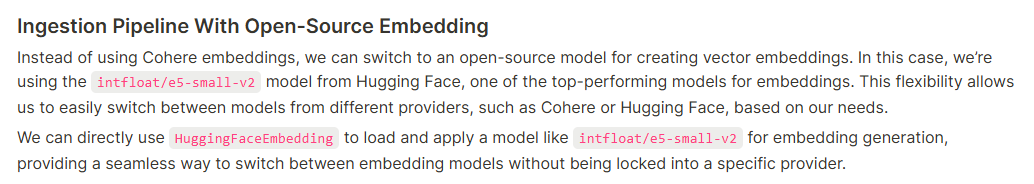

In [10]:
# import chromadb
# from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.vector_stores.qdrant import QdrantVectorStore
from qdrant_client import QdrantClient, AsyncQdrantClient, models as qdrant_models

# Open Source Embedding Model Collection

# chroma_client_ose = chromadb.PersistentClient(path="./mini-llama-articles-open-source-embed")
# chroma_collection_ose = chroma_client_ose.create_collection("mini-llama-articles-open-source-embed")

qdrant_client = QdrantClient(url=f"http://{os.getenv('qdrant_server_id')}:6333")
aclient = AsyncQdrantClient(url=f"http://{os.getenv('qdrant_server_id')}:6333")

collection_name = "mini-llama-articles-open-source-embed"

qdrant_collection_ose = qdrant_client.create_collection(
	collection_name = collection_name,
	vectors_config=qdrant_models.VectorParams(
        size=384, distance=qdrant_models.Distance.COSINE
    ),
)

# Define a storage context object using the created vector database.
# vector_store_ose = ChromaVectorStore(chroma_collection=chroma_collection_ose)

vector_store_ose = QdrantVectorStore(
    client=qdrant_client,
    aclient=aclient,
    collection_name=qdrant_collection_ose
)


Both client and aclient are provided. If using `:memory:` mode, the data between clients is not synced.


In [24]:
from llama_index.core.text_splitter import TokenTextSplitter

# Define the splitter object that split the text into segments with 512 tokens,
# with a 128 overlap between the segments.
text_splitter = TokenTextSplitter(separator=" ", chunk_size=512, chunk_overlap=128)


In [22]:
from llama_index.core.extractors import (
    SummaryExtractor,
    QuestionsAnsweredExtractor,
    KeywordExtractor,
)
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.ingestion import IngestionPipeline

from llama_index.llms.openai import OpenAI
from llama_index.llms.openrouter import OpenRouter

# llm_gpt = OpenAI(model="gpt-5-mini", additional_kwargs={"reasoning_effort": "minimal"})
llm_gpt = OpenRouter(
	model="openai/gpt-5-mini",
	api_key=os.getenv("OPENROUTER_API_KEY"),
	additional_kwargs={"reasoning_effort": "minimal"})


In [25]:

# Create the pipeline to apply the transformation on each chunk,
# and store the transformed text in the chroma vector store.
pipeline = IngestionPipeline(
    transformations=[
        text_splitter,
        QuestionsAnsweredExtractor(questions=3, llm=llm_gpt),
        SummaryExtractor(summaries=["prev", "self"], llm=llm_gpt),
        KeywordExtractor(keywords=10, llm=llm_gpt),
        HuggingFaceEmbedding(model_name="intfloat/e5-small-v2"),
    ],
    vector_store=vector_store_ose,
)

# Run the transformation pipeline.
nodes_ose = pipeline.run(documents=documents, show_progress=True)

Parsing nodes:   0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 108/108 [01:33<00:00,  1.16it/s]


Generating embeddings:   0%|          | 0/108 [00:00<?, ?it/s]

Collection True already exists, skipping collection creation.


In [26]:
print(len(nodes_ose))
print(len(nodes_ose[0].embedding))

108
384


In [ ]:
# Compress the vector store directory to a zip file to be able to download and use later.
# !zip -r vectorstore_open_source_embed.zip mini-llama-articles-open-source-embed

  adding: mini-llama-articles-open-source-embed/ (stored 0%)
  adding: mini-llama-articles-open-source-embed/677b1256-c682-4a5c-af8e-04d4f5c5e14b/ (stored 0%)
  adding: mini-llama-articles-open-source-embed/677b1256-c682-4a5c-af8e-04d4f5c5e14b/link_lists.bin (stored 0%)
  adding: mini-llama-articles-open-source-embed/677b1256-c682-4a5c-af8e-04d4f5c5e14b/header.bin (deflated 61%)
  adding: mini-llama-articles-open-source-embed/677b1256-c682-4a5c-af8e-04d4f5c5e14b/length.bin (deflated 79%)
  adding: mini-llama-articles-open-source-embed/677b1256-c682-4a5c-af8e-04d4f5c5e14b/data_level0.bin (deflated 100%)
  adding: mini-llama-articles-open-source-embed/chroma.sqlite3 (deflated 72%)


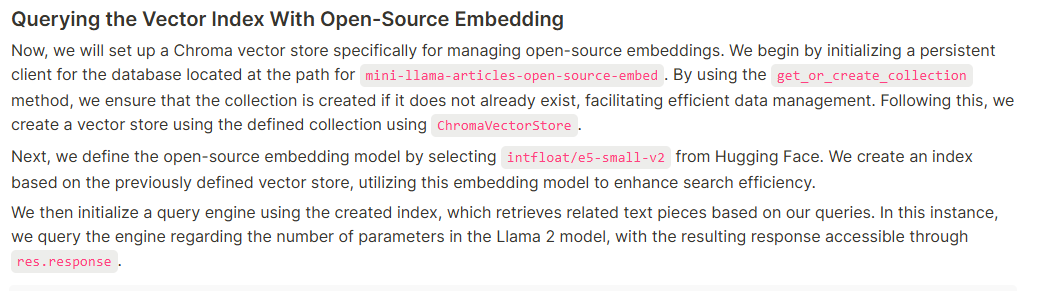

In [ ]:
# Load the vector store from the local storage.
# db_ose = chromadb.PersistentClient(path="./mini-llama-articles-open-source-embed")
# chroma_collection_ose = db_ose.get_or_create_collection("mini-llama-articles-open-source-embed")
# vector_store_ose = ChromaVectorStore(chroma_collection=chroma_collection_ose)

# vector_store_ose = QdrantVectorStore(
#     client=qdrant_client,
#     aclient=aclient,
#     collection_name=qdrant_collection_ose,
# )

In [28]:
from llama_index.core import VectorStoreIndex

# Define the Huggingface Embedding Model
embed_model_e5 = HuggingFaceEmbedding(model_name="intfloat/e5-small-v2")

# Create the index based on the vector store.
index_ose = VectorStoreIndex.from_vector_store( vector_store_ose, embed_model = embed_model_e5)

# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.
query_engine_ose = index_ose.as_query_engine(
	llm=llm_gpt, similarity_top_k=5)

res = query_engine_ose.query("How many parameters LLaMA 2 model has?")

res.response

'Llama 2 is available in four parameter sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters.\n\n2. The 7B and 34B Llama 2 variants outperform Falcon and outperform MPT in most categories; the exception is coding, where MPT outperforms some Llama 2 variants.\n\n3. ChatGPT‑4 notably outperforms Llama 2 on coding and math benchmarks—specifically HumanEval for coding and GSM8k for math.'

In [29]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 9a849756-8bb1-4b78-92fb-e8dd28f257f2
Title	 Meta's Llama 2: Revolutionizing Open Source Language Models for Commercial Use
Text	 I. Llama 2: Revolutionizing Commercial Use Unlike its predecessor Llama 1, which was limited to research use, Llama 2 represents a major advancement as an open-source commercial model. Businesses can now integrate Llama 2 into products to create AI-powered applications. Availability on Azure and AWS facilitates fine-tuning and adoption. However, restrictions apply to prevent exploitation. Companies with over 700 million active daily users cannot use Llama 2. Additionally, its output cannot be used to improve other language models.  II. Llama 2 Model Flavors Llama 2 is available in four different model sizes: 7 billion, 13 billion, 34 billion, and 70 billion parameters. While 7B, 13B, and 70B have already been released, the 34B model is still awaited. The pretrained variant, trained on a whopping 2 trillion tokens, boasts a context window of 4096 toke

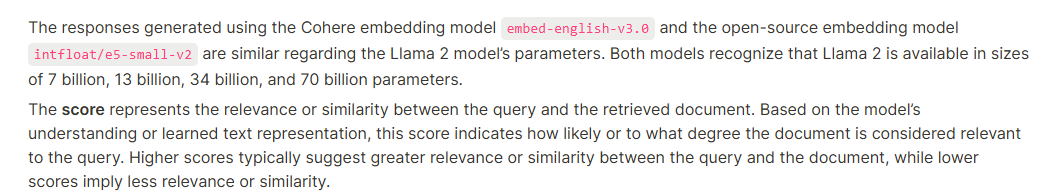

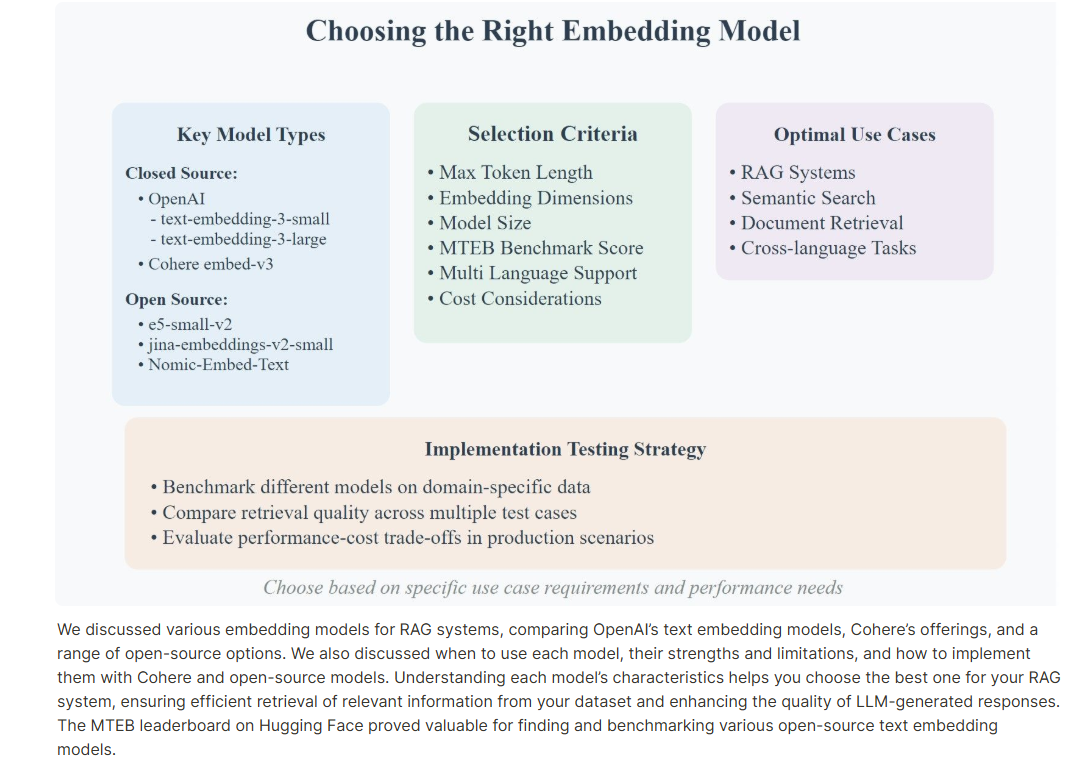